<h3>Step #0. Fire the system</h3>

In [1]:
# Import modules and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime
import plotly.graph_objects as go # for visualization
import os
import sys 
sys.path.append("../../Function/")
import function 

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

%matplotlib inline

<h3>Step #1. Read data</h3>

In [2]:
# Importing Training Set
df = pd.read_excel('../../../site_info_ver_4_lite.xlsx')

In [ ]:
sites = df.Site_Name.unique()
sites

In [3]:
dataset = df.copy()
dataset = dataset.loc[(dataset['Site_Name']==dataset.Site_Name.unique()[2])]
site_name = dataset.Site_Name.unique()[0]
# dataset_train.set_index("Date",inplace=True)
dataset[['so2','nox','pm10','pm2.5', 'is_Site_exceeded_nox', 'is_Site_exceeded_so2', 'is_Site_exceeded_pm10', 'is_Site_exceeded_pm2.5']].isna().sum()
dataset.drop(['so2','nox','pm10','pm2.5','is_Site_exceeded_nox', 'is_Site_exceeded_so2', 'is_Site_exceeded_pm10', 'is_Site_exceeded_pm2.5','Day_before_Total','Tourists_Count', 'Total'],axis=1,inplace=True)
dataset = function.remove_unique_one(dataset)
dataset = function.remove_high_corr(dataset, 'Israelis_Count')
# dataset = function.remove_outliers(dataset , 'Israelis_Count')
dataset = function.split_date(dataset)
tmp = dataset.Israelis_Count
dataset.drop('Israelis_Count',axis=1,inplace=True)
dataset['Israelis_Count']=tmp
# dataset.set_index('Date',inplace=True)
print(dataset.columns)
dataset.head(1)

Split Data Successfully
Index(['Date', 'is_weekend', 'operations', 'is_jewish_holiday',
       'is_muslims_holiday', 'Temperature', 'is_HeatWave', 'Haifa_pm10',
       'Haifa_pm2.5', 'Jerusalem_nox', 'Beer-Sheva_nox', 'Tel_Aviv-Yafo_so2',
       'Jerusalem_so2', 'Haifa_so2', 'Ashkelon_so2', 'Beer-Sheva_so2',
       'Tel_Aviv-Yafo_pm10_exceeded', 'Haifa_pm10_exceeded',
       'Ashkelon_pm10_exceeded', 'Tel_Aviv-Yafo_pm2.5_exceeded',
       'Jerusalem_pm2.5_exceeded', 'Haifa_pm2.5_exceeded',
       'Ashkelon_pm2.5_exceeded', 'Beer-Sheva_pm2.5_exceeded',
       'Tel_Aviv-Yafo_nox_exceeded', 'Jerusalem_nox_exceeded',
       'Haifa_nox_exceeded', 'Ashkelon_nox_exceeded', 'Season_autumn',
       'Season_spring', 'Season_summer', 'Season_winter', 'day', 'month',
       'year', 'Israelis_Count'],
      dtype='object')


,Date,is_weekend,operations,is_jewish_holiday,is_muslims_holiday,Temperature,is_HeatWave,Haifa_pm10,Haifa_pm2.5,Jerusalem_nox,...,Haifa_nox_exceeded,Ashkelon_nox_exceeded,Season_autumn,Season_spring,Season_summer,Season_winter,day,month,year,Israelis_Count
0,2016-01-01,1,0,0,0,18.7,0,23.3,26.2,501.7,...,1,0,0,0,0,1,1,1,2016,44


<h5>Get past information from year before</h5>

In [4]:
def last_year_entries_info(dataframe,target):
    #get last year info
    dataframe['Last_year_visitors'] = dataframe.apply(lambda row : last_year_visitors(dataframe,row['day'],row['month'],row['year'],target) , axis = 1)
    
    #make use of group day to fill null values based on avg 
    groups = make_groups(dataframe , target)
    
    #getting the indexes where its null
    mask = dataframe['Last_year_visitors'].isna()
    #fill the nulls
    dataframe.loc[mask, 'Last_year_visitors'] = dataframe.loc[dataframe['Last_year_visitors'].isna()].apply(lambda row :fill_last_year_nulls(groups,row['day'],row['month'],target),axis=1)

    return dataframe


In [5]:
import datetime

def make_groups(dataframe,target):
    #getting the mean value for every day and month. it returns a dataframe of the results.
    return dataframe.groupby(['day','month'])[target].mean().reset_index()

def fill_last_year_nulls(groups,day,month,target):
    #fill the nulls from the groups we made
    return int(groups.loc[(groups['day'] == day) & (groups['month'] == month)][target])


def last_year_visitors(dataframe,day,month,year,target):
    #Extract the visitors 
    visitors_last_year = dataframe.loc[(dataframe['day'] == day) &(dataframe['month'] == month) & (dataframe['year'] == year-1)][target]    
    #Return the value
    if visitors_last_year.empty:
        return None
    else : return int(visitors_last_year)

# dataset['Last_year_visitors'] = dataset.apply(lambda row : last_year_visitors(dataset,row['day'],row['month'],row['year'],'Israelis_Count') , axis = 1)


In [ ]:
# mask = dataset['Last_year_visitors'].isna()
# dataset.loc[mask, 'Last_year_visitors'] = dataset.loc[dataset['Last_year_visitors'].isna()].apply(lambda row :fill_last_year_nulls(row['day'],row['month']),axis=1)

In [6]:
dataset = last_year_entries_info(dataset,'Israelis_Count')

In [7]:
cols = dataset.columns.tolist()
extra_col = cols[-1]
cols = cols[:-1]
cols.insert(-1 , extra_col)
print(cols)
dataset = dataset[cols]

['Date', 'is_weekend', 'operations', 'is_jewish_holiday', 'is_muslims_holiday', 'Temperature', 'is_HeatWave', 'Haifa_pm10', 'Haifa_pm2.5', 'Jerusalem_nox', 'Beer-Sheva_nox', 'Tel_Aviv-Yafo_so2', 'Jerusalem_so2', 'Haifa_so2', 'Ashkelon_so2', 'Beer-Sheva_so2', 'Tel_Aviv-Yafo_pm10_exceeded', 'Haifa_pm10_exceeded', 'Ashkelon_pm10_exceeded', 'Tel_Aviv-Yafo_pm2.5_exceeded', 'Jerusalem_pm2.5_exceeded', 'Haifa_pm2.5_exceeded', 'Ashkelon_pm2.5_exceeded', 'Beer-Sheva_pm2.5_exceeded', 'Tel_Aviv-Yafo_nox_exceeded', 'Jerusalem_nox_exceeded', 'Haifa_nox_exceeded', 'Ashkelon_nox_exceeded', 'Season_autumn', 'Season_spring', 'Season_summer', 'Season_winter', 'day', 'month', 'year', 'Last_year_visitors', 'Israelis_Count']


In [8]:
dataset=dataset.set_index('Date')

In [9]:
cols = list(dataset.columns)
TargetVariable=['Israelis_Count']
Predictors=cols[:-1]
 
X= dataset[Predictors].values
y= dataset[TargetVariable].values
 
### Sandardization of data ###
from sklearn.preprocessing import StandardScaler
PredictorScaler=StandardScaler()
TargetVarScaler=StandardScaler()
 
# Storing the fit object for later reference
PredictorScalerFit=PredictorScaler.fit(X)
# TargetVarScalerFit=TargetVarScaler.fit(y)
 
# Generating the standardized values of X and y
X= PredictorScalerFit.transform(X)
y= np.log(y + 0.001)
 
# Split the data into training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
 
# Quick sanity check with the shapes of Training and testing datasets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1344, 35)
(1344, 1)
(576, 35)
(576, 1)


In [12]:
# create ANN model
model = Sequential()
 
# Defining the Input layer and FIRST hidden layer, both are same!
model.add(Dense(units=5, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
 
# Defining the Second layer of the model
# after the first layer we don't have to specify input_dim as keras configure it automatically
model.add(Dense(units=5, kernel_initializer='normal', activation='tanh'))
 
# The output neuron is a single fully connected node 
# Since we will be predicting a single number
model.add(Dense(1, kernel_initializer='normal'))
 
# Compiling the model
model.compile(loss='mean_squared_error', optimizer='adam')

# es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=15, verbose=1)
# rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, verbose=1)
# mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

# tb = TensorBoard('logs')
 
# Fitting the ANN to the Training set
model.fit(X_train, y_train ,batch_size = 20, epochs = 150, verbose=1 ,validation_data=(X_test,y_test), validation_split=0.2)

Epoch 1/150
54/54 [==============================] - 1s 8ms/step - loss: 44.9382 - val_loss: 43.6766
Epoch 2/150
54/54 [==============================] - 0s 4ms/step - loss: 42.9617 - val_loss: 40.5879
Epoch 3/150
54/54 [==============================] - 0s 4ms/step - loss: 37.9254 - val_loss: 33.5187
Epoch 4/150
54/54 [==============================] - 0s 4ms/step - loss: 29.6785 - val_loss: 25.2159
Epoch 5/150
54/54 [==============================] - 0s 4ms/step - loss: 22.6731 - val_loss: 19.6310
Epoch 6/150
54/54 [==============================] - 0s 6ms/step - loss: 17.9821 - val_loss: 15.8429
Epoch 7/150
54/54 [==============================] - 0s 4ms/step - loss: 14.6207 - val_loss: 12.9817
Epoch 8/150
54/54 [==============================] - 0s 4ms/step - loss: 12.0325 - val_loss: 10.7276
Epoch 9/150
54/54 [==============================] - 0s 4ms/step - loss: 9.9589 - val_loss: 8.8910
Epoch 10/150
54/54 [==============================] - 0s 4ms/step - loss: 8.2631 - val_loss: 

In [ ]:
# Defining a function to find the best parameters for ANN
def FunctionFindBestParams(X_train, y_train, X_test, y_test):
    
    # Defining the list of hyper parameters to try
    batch_size_list=[5, 10, 15, 20]
    epoch_list  =   [5, 10, 50, 100]
    
    import pandas as pd
    SearchResultsData=pd.DataFrame(columns=['TrialNumber', 'Parameters', 'Accuracy'])
    
    # initializing the trials
    TrialNumber=0
    for batch_size_trial in batch_size_list:
        for epochs_trial in epoch_list:
            TrialNumber+=1
            # create ANN model
            model = Sequential()
            # Defining the first layer of the model
            model.add(Dense(units=5, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
 
            # Defining the Second layer of the model
            model.add(Dense(units=5, kernel_initializer='normal', activation='relu'))
 
            # The output neuron is a single fully connected node 
            # Since we will be predicting a single number
            model.add(Dense(1, kernel_initializer='normal'))
 
            # Compiling the model
            model.compile(loss='mean_squared_error', optimizer='adam')
 
            # Fitting the ANN to the Training set
            model.fit(X_train, y_train ,batch_size = batch_size_trial, epochs = epochs_trial, verbose=0)
 
            MAPE = np.mean(100 * (np.abs(y_test-model.predict(X_test))/y_test))
            
            # printing the results of the current iteration
            print(TrialNumber, 'Parameters:','batch_size:', batch_size_trial,'-', 'epochs:',epochs_trial, 'Accuracy:', 100-MAPE)
            
            SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, str(batch_size_trial)+'-'+str(epochs_trial), 100-MAPE]],
                                                                    columns=['TrialNumber', 'Parameters', 'Accuracy'] ))
    return(SearchResultsData)
 
 
######################################################
# Calling the function
ResultsData=FunctionFindBestParams(X_train, y_train, X_test, y_test)

In [ ]:

%matplotlib inline
ResultsData.plot(x='Parameters', y='Accuracy', figsize=(15,4), kind='line')

In [15]:
# Fitting the ANN to the Training set
model.fit(X_train, y_train ,batch_size = 5, epochs = 100, verbose=0)
# Generating Predictions on testing data
Predictions=model.predict(X_test)
 
# Scaling the predicted Price data back to original price scale
Predictions=np.exp(Predictions)
 
# Scaling the y_test Price data back to original price scale
y_test_orig=np.exp(y_test)
 
# Scaling the test data back to original scale
Test_Data=PredictorScalerFit.inverse_transform(X_test)
 
TestingData=pd.DataFrame(data=Test_Data, columns=Predictors)
TestingData['Entries']=y_test_orig
TestingData['PredictedEntries']=Predictions
TestingData.head()

,is_weekend,operations,is_jewish_holiday,is_muslims_holiday,Temperature,is_HeatWave,Haifa_pm10,Haifa_pm2.5,Jerusalem_nox,Beer-Sheva_nox,...,Season_autumn,Season_spring,Season_summer,Season_winter,day,month,year,Last_year_visitors,Entries,PredictedEntries
0,1.0,0.0,1.0,0.0,37.372310,1.0,104.6,159.6,489.3,48.7,...,0.0,0.0,1.0,-2.775558e-17,28.0,9.0,2018.0,297.0,2292.001,837.708313
1,0.0,0.0,0.0,1.0,23.812455,1.0,102.2,141.9,1137.2,58.7,...,0.0,0.0,1.0,-2.775558e-17,3.0,8.0,2020.0,710.0,1363.001,780.059692
2,0.0,0.0,0.0,1.0,39.933333,1.0,86.2,61.1,785.5,76.7,...,0.0,0.0,1.0,-2.775558e-17,4.0,9.0,2017.0,128.0,161.001,902.849854
3,0.0,0.0,1.0,0.0,38.700000,1.0,53.0,59.8,576.3,39.5,...,0.0,1.0,0.0,-2.775558e-17,30.0,5.0,2017.0,1740.0,823.001,1566.645996
4,1.0,0.0,0.0,0.0,20.200000,0.0,42.9,51.8,299.7,42.8,...,0.0,0.0,0.0,1.000000e+00,18.0,2.0,2017.0,1800.0,848.001,817.927551


rmse 744.423931726373
std test 809.6264151439017


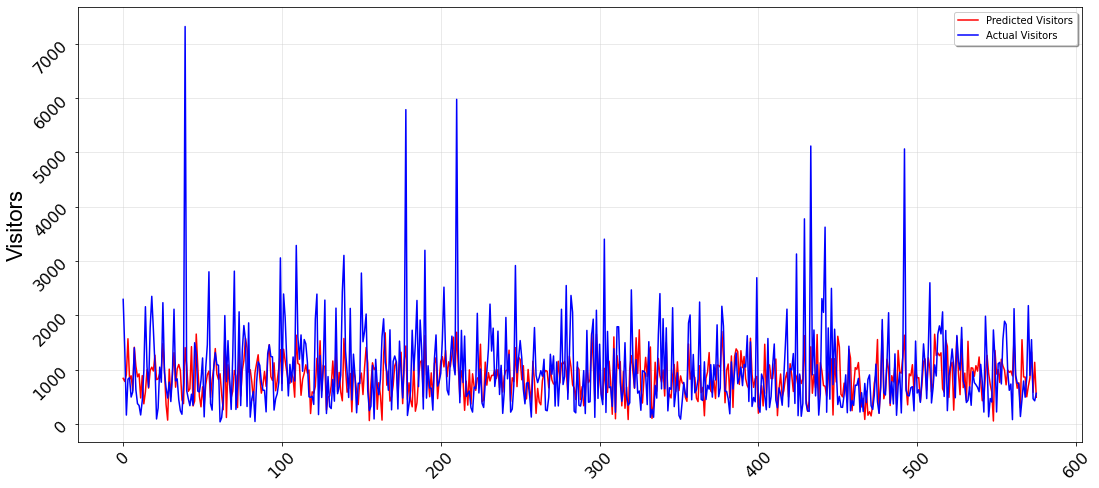

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


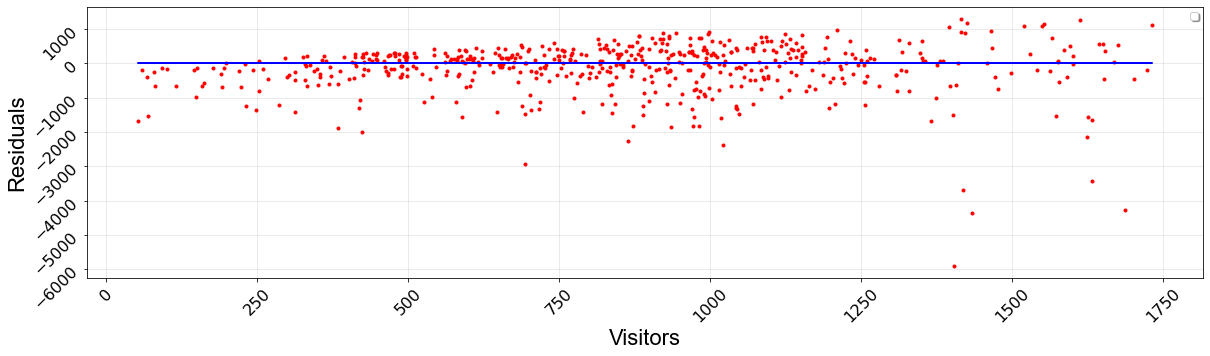

In [16]:
import warnings
warnings.filterwarnings('ignore')
# Set plot size 
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

TestingData['TestingDataiduals'] = TestingData['PredictedEntries'] - TestingData['Entries']

from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(TestingData['PredictedEntries'],TestingData['Entries']))
print('rmse',rmse)
print('std test',np.std(TestingData['Entries']))

rmse_str = str(round(rmse,2))

# Check whether the specified path exists or not

function.plot_line(
  prediction=TestingData.PredictedEntries,
  actual=TestingData.Entries
  )

function.plot_residuals(
  prediction=TestingData.PredictedEntries,
  actual=TestingData.Entries,
  fig_size_tuple=(20,5)
  )

In [ ]:
n_predict = 1   # Number of days we want top predict into the future
n_past = 2   # Number of past days we want to use to predict the future
cols = dataset.drop("Date",axis=1).columns
target='Israelis_Count'
target_title='Israelis'
def X_y_data(dataset):
    # Select features (columns) to be involved intro training and predictions

    # Extract dates (will be used in visualization)
    datelist = list(dataset['Date'])
    
    # datelist = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in datelist]
    dataset=dataset.set_index('Date')
    print('set shape == {}'.format(dataset.shape))
    print('All timestamps == {}'.format(len(datelist)))
    print('Featured selected: {}'.format(cols))
    dataset = dataset[cols].astype(str)
    for i in cols:
        for j in dataset.index:
            dataset[i][j] = dataset[i][j].replace(',', '')

    dataset = dataset.astype(float)

    # Using multiple features (predictors)
    training_set = dataset.values

    print('Shape of set == {}.'.format(training_set.shape))
    print(training_set)

    #first get log from visitors : 
    
    a = training_set[:,:-1]
    b = np.log(training_set[:,-1]+0.001)
    print('a',a.shape,a)
    print('b',b.shape,b)
    # np.reshape(b, b.shape[0],)
    training_set = np.insert(a, len(cols)-1,values=b, axis=1) # Insert values before column 3

    print('training_set\n',training_set)
    # Feature Scaling
    from sklearn.preprocessing import StandardScaler

    sc = StandardScaler()
    training_set_scaled = sc.fit_transform(training_set)

    sc_predict = StandardScaler()
    sc_predict.fit_transform(training_set[:, -1:])
    # Creating a data structure with 90 timestamps and 1 output
    X_train = []
    y_train = []



    for i in range(n_past, len(training_set_scaled) - n_predict +1):
        X_train.append(training_set_scaled[i - n_past:i,:])
        y_train.append(training_set_scaled[i + n_predict - 1:i + n_predict,-1])
    print()

    return dataset,datelist,np.array(X_train), np.array(y_train),sc_predict
size = round(len(dataset)*0.85)

dataset_train = dataset[:size]
dataset_test = dataset[size:]
print('Training print')
print()
dataset_train,datelist_train,X_train, y_train,sc_predict_train = X_y_data(dataset_train)

print('Testing print')
print()
dataset_test,datelist_test,X_test, y_test,sc_predict_test = X_y_data(dataset_test)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))
print('X_test shape == {}.'.format(X_test.shape))
print('y_test shape == {}.'.format(y_test.shape))


<h2>PART 2. Create a model. Training</h2>

<h3>Step #3. Building the GRU based Neural Network</h3>

In [11]:
# Import Libraries and packages from Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU
from keras.layers import Dropout
# from keras.optimizers import ADAM

In [ ]:
from keras import backend
 
def rmse(y_true, y_pred):
	return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

# Initializing the Neural Network based on GRU
model = Sequential()

# Adding 1st GRU layer
model.add(GRU(units=128, return_sequences=True, input_shape=(n_past, dataset_train.shape[1])))
# Adding Dropout
model.add(Dropout(0.35))
# Adding 2nd GRU layer
model.add(GRU(units=128, return_sequences=True))

# Adding Dropout
model.add(Dropout(0.25))

model.add(GRU(units=128, return_sequences=True))

# Adding Dropout
model.add(Dropout(0.25))

model.add(GRU(units=64, return_sequences=True))

# Adding Dropout
model.add(Dropout(0.25))

model.add(GRU(units=64, return_sequences=True))

# Adding Dropout
model.add(Dropout(0.25))

model.add(GRU(units=32, return_sequences=True))

# Adding Dropout
model.add(Dropout(0.25))
model.add(GRU(units=32, return_sequences=True))

# Adding Dropout
model.add(Dropout(0.25))
model.add(GRU(units=16, return_sequences=False))

# Adding Dropout
model.add(Dropout(0.25))
# Output layer
model.add(Dense(units=1))

# Compiling the Neural Network
model.compile(optimizer = 'adam', loss=[rmse],metrics='mean_squared_error')

<h3>Step #4. Start training</h3>

In [ ]:
%%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=15, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train, y_train, shuffle=True, epochs=100, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=1)

<p>
Notes:<br>
<ul>
<li><b>EarlyStopping</b> - Stop training when a monitored metric has stopped improving.</li>
<li><code>monitor</code> - quantity to be monitored.</li>
<li><code>min_delta</code> - minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than <code>min_delta</code>, will count as no improvement.</li>
<li><code>patience</code> - number of epochs with no improvement after which training will be stopped.</li>
</ul>

<ul>
<li><b>ReduceLROnPlateau</b> - Reduce learning rate when a metric has stopped improving.</li>
<li><code>factor</code> - factor by which the learning rate will be reduced. <code>new_lr = lr * factor</code>.</li>
</ul>
</p>

<hr>

<p>
The last date for our training set is <code>30-Dec-2016</code>.<br>
</p>

<p>
We will perform predictions for the next <b>20</b> days, since <b>2017-01-01</b> to <b>2017-01-20</b>.
</p>

<h2>PART 3. Make future predictions</h2>

In [ ]:
# # Generate list of sequence of days for predictions
# datelist_future = pd.date_range(datelist_train[-1], periods=n_predict, freq='1d').tolist()
# datelist_future


In [ ]:
'''
Remeber, we have datelist_train from begining.
'''

# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_test:
    datelist_future_.append(this_timestamp.date())
# datelist_future_

<h3>Step #5. Make predictions for future dates</h3>

In [ ]:
# Perform predictions
model.load_weights('weights.h5')
predictions_future = model.predict(X_test)
len(predictions_future)
# predictions_train = model.predict(X_train[n_past:])

In [ ]:
# Inverse the predictions to original measurements

# ---> Special function: convert <datetime.date> to <Timestamp>
def datetime_to_timestamp(x):
    '''
        x : a given datetime value (datetime.date)
    '''
    return datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')


y_pred_future = np.exp(sc_predict_test.inverse_transform(predictions_future))
# y_pred_train = np.exp(sc_predict_train.inverse_transform(predictions_train))
print(predictions_future.shape)


PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=[target]).set_index(pd.Series(datelist_test[n_past:]))
# PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=[target]).set_index(pd.Series(datelist_train[2 * n_past + n_predict -1:]))

# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
# PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series().apply(datetime_to_timestamp)

PREDICTIONS_FUTURE.head(3)

<h3>Step #6. Visualize the Predictions</h3>

In [ ]:
import warnings
warnings.filterwarnings('ignore')
# Set plot size 
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

res = pd.merge(PREDICTIONS_FUTURE[target], dataset_test[target],left_index=True,right_index=True)
res.columns=['Predictions','Actual']
res['residuals'] = res['Predictions'] - res['Actual']

from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(res['Predictions'],res['Actual']))
print('rmse',rmse)
print('std test',np.std(res['Actual']))

rmse_str = str(round(rmse,2))

# Check whether the specified path exists or not
path = 'LSTM_models/model_Eilat/mod1_rmse'+rmse_str
isExist = os.path.exists(path)
if not isExist:
  os.makedirs(path)
model.save(path)

function.plot_line(
  prediction=res.Predictions,
  actual=res.Actual,
  title=target_title+' Predcitions and Acutal Visitors at '+site_name,
  path_save='LSTM_models/model_Eilat/',
  file_name='mod1_rmse'+ rmse_str+ '.png'
  )

function.plot_residuals(
  prediction=res.Predictions,
  actual=res.Actual,
  title='Residuals '+site_name,
  path_save='LSTM_models/model_Eilat/',
  file_name='mod1_rmse'+ rmse_str+ 'residuals.png',
  fig_size_tuple=(20,5)
  )


In [ ]:
# Parse training set timestamp for better visualization
dataset_train = pd.DataFrame(dataset_train, columns=cols)
dataset_train.index = datelist_train
dataset_train.index = pd.to_datetime(dataset_train.index)

In [ ]:
%pip install lime
import lime
import lime.lime_tabular
# from lime.lime_text import RecurrentTabularExplainer
class_names=['Israelis_Count']

categorical_features = np.argwhere(
    np.array([len(set(dataset_train.values[:,x]))
    for x in range(dataset_train.values.shape[1])]) <= 10).flatten()
print(dataset_train.columns.shape)
print(categorical_features.shape)
print(X_train.shape)

explainer = lime.lime_tabular.RecurrentTabularExplainer(X_train, 
                                                   feature_names=dataset_train.columns,
                                                   class_names=['price'], 
                                                   categorical_features=categorical_features, 
                                                   verbose=True, mode='regression')

In [ ]:
exp = explainer.explain_instance(X_test[0],model.predict,num_features=10)
exp.show_in_notebook(show_table=True)